# Prédiction de la consommation totale d'énergie

#### Contexte :

A l'aide de relevés déjà effectué par les agents de la ville de Seattle, nous allons tenter de prédire la consommation totale énergétique des bâtiments non résidentiels. 

Nous travaillons sur les données, récupérées depuis le site de Seattle, dont le nettoyage et prétraitement a été réalisé dans le notebook précédent.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings



In [2]:
data = pd.read_csv("final_data_2.csv", sep = ",")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              4698 non-null   int64  
 1   BuildingType               4698 non-null   object 
 2   PrimaryPropertyType        4698 non-null   object 
 3   CouncilDistrictCode        4698 non-null   float64
 4   Neighborhood               4698 non-null   object 
 5   Latitude                   4698 non-null   float64
 6   Longitude                  4698 non-null   float64
 7   NumberofBuildings          4698 non-null   float64
 8   NumberofFloors             4698 non-null   float64
 9   PropertyGFATotal           4698 non-null   int64  
 10  PropertyGFAParking         4698 non-null   float64
 11  PropertyGFABuilding(s)     4698 non-null   float64
 12  LargestPropertyUseType     4698 non-null   object 
 13  LargestPropertyUseTypeGFA  4698 non-null   float

#### ENERGYSTRARScore : 
on va isoler cette variable pour évaluer sa perfomance par la suite

In [4]:
energy_star_score = data['ENERGYSTARScore']
data = data.drop(columns= 'ENERGYSTARScore')
data.shape

(4698, 20)

Nous allons également supprimer les colonnes :

    - TotalGHGEmissions (variable cible du prochain notebook)
    - OSEBuildingID (variable d'identification que nous n'allons pas utiliser dans la prédiction)

In [5]:
data = data.drop(columns=['TotalGHGEmissions', 'OSEBuildingID'])
data.shape

(4698, 18)

Redéfinir les types des variables catégorielles :

In [6]:
categorical_var=["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType", "CouncilDistrictCode"]
data[categorical_var] = data[categorical_var].astype('category')

In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4698 entries, 0 to 4697
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BuildingType               4698 non-null   category
 1   PrimaryPropertyType        4698 non-null   category
 2   CouncilDistrictCode        4698 non-null   category
 3   Neighborhood               4698 non-null   category
 4   Latitude                   4698 non-null   float64 
 5   Longitude                  4698 non-null   float64 
 6   NumberofBuildings          4698 non-null   float64 
 7   NumberofFloors             4698 non-null   float64 
 8   PropertyGFATotal           4698 non-null   int64   
 9   PropertyGFAParking         4698 non-null   float64 
 10  PropertyGFABuilding(s)     4698 non-null   float64 
 11  LargestPropertyUseType     4698 non-null   category
 12  LargestPropertyUseTypeGFA  4698 non-null   float64 
 13  SiteEnergyUse(kBtu)        4698 n

In [8]:
data = data.reindex(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'Neighborhood', 'CouncilDistrictCode', 'BuildingAge',
                     'Latitude', 'Longitude', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
                     'LargestPropertyUseTypeGFA','PropertyGFAParking', 'Building_Rate', 'Largest_Use_Rate', 'Parking_Rate', 
                     'SiteEnergyUse(kBtu)'], axis=1) 

In [9]:
data.columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
       'Neighborhood', 'CouncilDistrictCode', 'BuildingAge', 'Latitude',
       'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'PropertyGFAParking', 'Building_Rate', 'Largest_Use_Rate',
       'Parking_Rate', 'SiteEnergyUse(kBtu)'],
      dtype='object')

## Sommaire :

### 1. Prétraitement : 
- Split train - test
- Transformation log de la variable cible
- Encodage : TargetEncoder en utlisant la varible cible: SiteEnergyUse(kBtu)
- Selection de features : méthode RFECV (basée sur différents modèles)
- Transformation inverse variable cible
### 2. Validation croisée :
- standardisation (RobustScaler)
- Prédiction (test avec différents modèle)

### 3. Modèles prédiction et RFECV : 

- Modèle linéaire :
     - LinearRegression
     - RidgeCv
     - LassoCv
     - ElasticNetCv
  
- Modèles non linéaires
  
    - KernelRidge
    - SVR
      
- Méthodes ensemblistes
  
    - Random Forest Regressor
    - XGBoost 
  
### 4. Evaluation des performances : validation croisée et test

    - R2
    - RMSE
    - RMSE relatif
    - MAE (mean absolute error)
    - Median absolute error
    - Temps d'entrainement
    - Temps de prédiction
    - Comparaison des distribution vraie valeur et prédiction

In [10]:
# Libraries 

import category_encoders
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFECV
from sklearn.kernel_ridge import KernelRidge
import time
import math

In [11]:
# Fonction transformation log de la variable cible
def target_transformation(value):
    return np.log(value)

# Fonction encodage :
def encodage(X_train, X_test, y_train):
    encoder = category_encoders.TargetEncoder()
    encoded_features = []
    
    for feature in X_train.columns:
        if X_train[feature].dtype.name == 'category':
            encoder.fit(X_train[feature], y_train)
            
            # Appliquez l'encodage à la fois sur X_train et X_test
            X_train[f'{feature}_encoded'] = encoder.transform(X_train[feature])
            X_test[f'{feature}_encoded'] = encoder.transform(X_test[feature])
            encoded_features.append(f'{feature}_encoded')
    
    return X_train[encoded_features], X_test[encoded_features]

In [12]:
# Séparation features et cible
target = "SiteEnergyUse(kBtu)"
X = data.drop([target], axis=1)
y = data[target]

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation des variable numériques et catégorielles pour l'encodage
train_categorical_features = X_train.select_dtypes(include='category')
test_categorical_features = X_test.select_dtypes(include='category')

train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])

# Transformation de la variable cible
y_train_log = y_train.apply(target_transformation)

# Encodage des variables catégorielles
train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train_log)

# Fusion des variables catégorielles et numériques
X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

print("Données d'entraînement : ", X_train.shape)
print("Données de test : ", X_test.shape)

Données d'entraînement :  (3758, 17)
Données de test :  (940, 17)


In [13]:
# Sélection de features avec RFECV
rfe_model = LinearRegression()
sv = RFECV(rfe_model, step=1, cv=5)
sv.fit(X_train, y_train_log)
selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
X_train = X_train[selected_columns]
X_test = sv.transform(X_test)

# Accédez aux classements des fonctionnalités
feature_ranking = sv.ranking_
# Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
selected_features = sv.support_

feature_info = pd.DataFrame({
    'Feature': X.columns, 
    'Ranking': feature_ranking,
    'Selected': selected_features
})
print("Features Sélectionnées par la RFECV :")
display(feature_info)

Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,3,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,2,False


In [14]:
# fonction pretraitement

def preprocessing(data, target, rfe_model):
    # Séparation features et cible
    target = target
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=12)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    

    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    
    # Sélection de features avec RFECV
    
    sv = RFECV(rfe_model, step=1, cv=5)
    sv.fit(X_train, y_train)
    selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
    X_train = X_train[selected_columns]
    X_test = sv.transform(X_test)
    
    # Accédez aux classements des fonctionnalités
    feature_ranking = sv.ranking_
    # Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
    selected_features = sv.support_
    
    feature_info = pd.DataFrame({
        'Feature': X.columns, 
        'Ranking': feature_ranking,
        'Selected': selected_features
    })
    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)
    print("Features Sélectionnées par la RFECV :")
    display(feature_info)
    
    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = preprocessing(data, 'SiteEnergyUse(kBtu)', LinearRegression())

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


## I - Modèles linéaires :

- Test régression linéaire, variable cible transformée en log
- Comparaison regression linéaire variables cible transformée en log et variable cible non transformée

In [16]:
def evaluate_model(data, target, rfe_model, prediction_model):   
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = preprocessing(data, target, rfe_model)
    scaler = RobustScaler()
    
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)  
    ])
    
    # Ajuster le pipeline avec les données d'entraînement
    
    # Temps d'entraînement données log
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train
    
    # training score données log
    
    train_rmse = math.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    train_mae = mean_absolute_error(y_train, pipeline.predict(X_train))
    train_r2 = r2_score(y_train, pipeline.predict(X_train))
    train_med_abs_err = median_absolute_error(y_train, pipeline.predict(X_train))
    
    # Temps de prédiction données log
    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    
    # Mesures des performances - cible
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)

    y_test_trans = np.exp(y_test)
    y_pred_trans = np.exp(y_pred)
    mae_trans = mean_absolute_error(y_test_trans, y_pred_trans)
    r2_trans = r2_score(y_test_trans, y_pred_trans)
    rmse_trans = np.sqrt(mean_squared_error(y_test_trans, y_pred_trans))
    med_abs_err_trans = median_absolute_error(y_test_trans, y_pred_trans)

    print("Modèle : ", prediction_model)
    print("Scores avec la cible transformée en log puis exp")
    
    score_info = {"Training scores": [train_rmse, train_mae, train_r2, train_med_abs_err, training_time],
                  "Test scores log": [rmse, mae, r2, med_abs_err, prediction_time],
                  "Test scores": [rmse_trans, mae_trans, r2_trans, med_abs_err_trans, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['RMSE', 'MAE', 'R2', 'Median Abs Err', 'Time'])
    
    display(df_score_info)
    
    # ---------------------------------------------------------------------------------
    
    # Données non transformées (log_exp) 
    
    # Temps d'entraînement données log_exp
    y_train_exp = np.exp(y_train)
    y_test_exp = np.exp(y_test)
    
    start_train_exp = time.time()
    pipeline.fit(X_train, y_train_exp)
    end_train_exp = time.time()
    training_time_exp = end_train_exp - start_train_exp
    
    # training score données log_exp
    train_rmse_exp = math.sqrt(mean_squared_error(y_train_exp, pipeline.predict(X_train)))
    train_mae_exp = mean_absolute_error(y_train_exp, pipeline.predict(X_train))
    train_r2_exp = r2_score(y_train_exp, pipeline.predict(X_train))
    train_med_abs_err_exp = median_absolute_error(y_train_exp, pipeline.predict(X_train))
    train_relative_rmse = (train_rmse_exp/(y_train_exp.max() - y_train_exp.min()))*100
    
    # Temps de prédiction données log_exp
    start_pred_exp = time.time()
    y_pred_exp = pipeline.predict(X_test)
    end_pred_exp = time.time()
    prediction_time_exp = end_pred_exp - start_pred_exp
    
    # Mesures des performances - cible log_exp
    mae_exp = mean_absolute_error(y_test_exp, y_pred_exp)
    r2_exp = r2_score(y_test_exp, y_pred_exp)
    rmse_exp = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
    med_abs_err_exp = median_absolute_error(y_test_exp, y_pred_exp)
    relative_rmse_exp = (rmse_exp/(y_test_exp.max()-y_test_exp.min()))*100
    
    print("Scores avec cible non transformée")
    score_info_2 = {"Training scores": [train_r2_exp, train_rmse_exp, train_relative_rmse, train_mae_exp, train_med_abs_err_exp, training_time_exp],
                  "Test scores": [r2_exp, rmse_exp, relative_rmse_exp, mae_exp, med_abs_err_exp, prediction_time_exp]
                 }
    df_score_info_2 = pd.DataFrame(score_info_2,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])
    
    display(df_score_info_2)

    # Graphique données log
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    sns.distplot(y_test, ax = axes[0,0], label='Valeur log' )
    sns.distplot(y_pred, ax = axes[0,0], label='Prédiction')
    axes[0,0].set_title('Comparaison des distributions ')
    axes[0,0].legend()
    
    axes[0,1].scatter(y_test, y_pred, alpha=0.5)
    axes[0,1].plot([12, 20],[12, 20], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[0,1].set_xlabel("Valeur log")
    axes[0,1].set_ylabel("Prédiction")
    axes[0,1].set_title("Scatter Plot de valeurs log vs. prédictions")
    
    # Graphique données log_exp
    sns.distplot(y_test_exp, ax = axes[1,0], label='vraie Valeur' )
    sns.distplot(y_pred_exp, ax = axes[1,0], label='Prédiction')
    axes[1,0].set_title('Comparaison des distributions ')
    axes[1,0].legend()
    
    axes[1,1].scatter(y_test_exp, y_pred_exp, alpha=0.5)
    axes[1,1].plot([0, 1.2e8],[0, 1.2e8], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[1,1].set_xlabel("Vraie valeur")
    axes[1,1].set_ylabel("Prédiction")
    axes[1,1].set_title("Scatter Plot de Vraie valeurs vs. prédictions")
    plt.show()
    
    return df_score_info_2


### Modèle : LinearRegression
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  LinearRegression()
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,0.887398,0.990031,2.260726e+10
MAE,0.691703,0.741489,7.593305e+08
R2,0.490460,0.417487,-2.746254e+05
Median Abs Err,0.584075,0.584278,1.448050e+06
Time,0.013304,0.009681,9.681463e-03


Scores avec cible non transformée


,Training scores,Test scores
R2,7.798405e-01,5.611853e-01
RMSE,1.166853e+07,2.857705e+07
Relative RMSE,1.101901e+00,3.270574e+00
MAE,4.934051e+06,6.733883e+06
Median Abs Err,2.548144e+06,2.554921e+06
Time,2.560043e-02,3.081560e-03


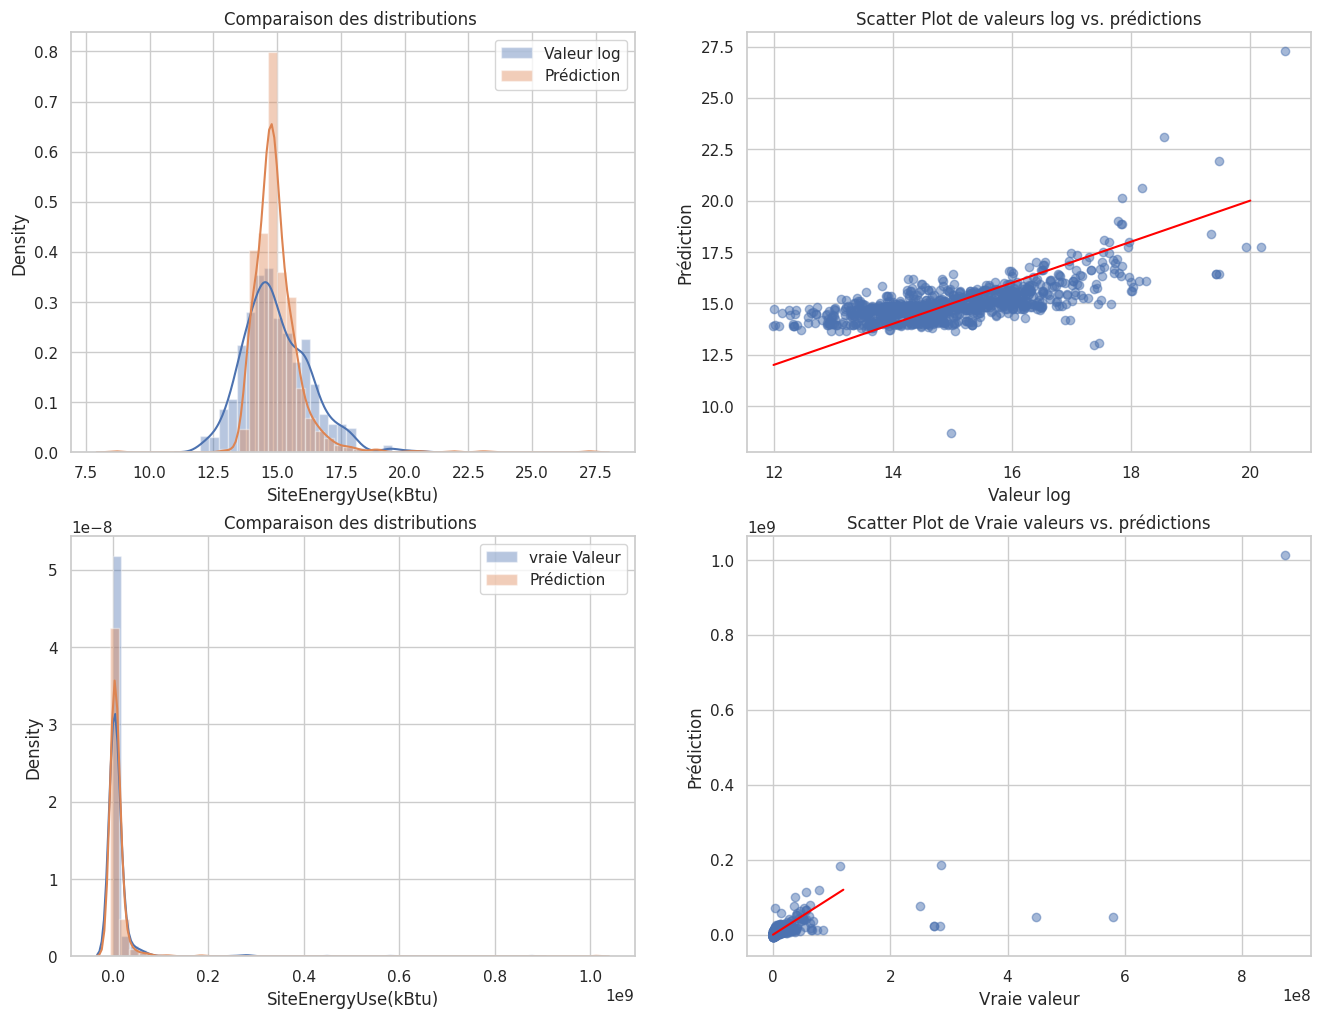

In [17]:
lr_score = evaluate_model(data, 'SiteEnergyUse(kBtu)', LinearRegression(), LinearRegression())

### Modèle : RidgeCV 
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  RidgeCV()
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,0.886807,0.990904,2.759716e+10
MAE,0.691686,0.741694,9.233279e+08
R2,0.491138,0.416460,-4.092364e+05
Median Abs Err,0.577726,0.585333,1.448369e+06
Time,0.074167,0.000601,6.012917e-04


Scores avec cible non transformée


,Training scores,Test scores
R2,7.799172e-01,5.607660e-01
RMSE,1.166649e+07,2.859070e+07
Relative RMSE,1.101708e+00,3.272136e+00
MAE,4.927545e+06,6.726776e+06
Median Abs Err,2.563883e+06,2.538244e+06
Time,8.587265e-02,1.486063e-03


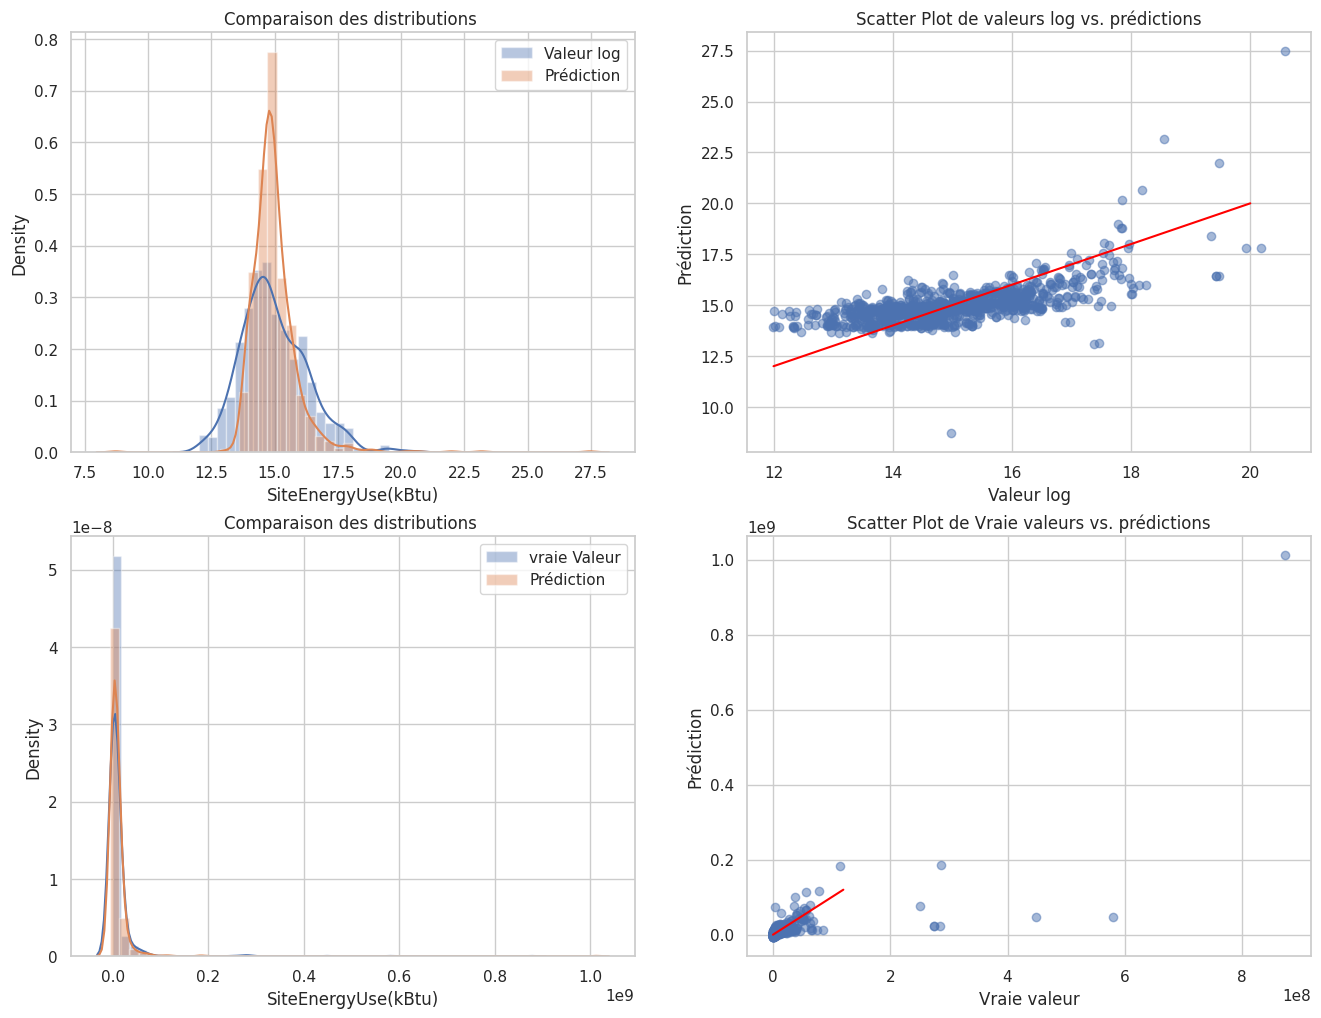

In [18]:
from sklearn.linear_model import RidgeCV
lr_Ridge_score = evaluate_model(data, 'SiteEnergyUse(kBtu)', LinearRegression(), RidgeCV(alphas=(0.1, 1.0, 10.0)))

### Modèle : LassoCV 
#### LinearRegression : pour la selection de features RFECV

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  LassoCV(alphas=(0.1, 1.0, 10.0))
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,0.917613,1.032476,1.632743e+12
MAE,0.711866,0.764441,5.326173e+10
R2,0.455171,0.366469,-1.432459e+09
Median Abs Err,0.598172,0.604125,1.456897e+06
Time,0.079113,0.004128,4.127741e-03


Scores avec cible non transformée


,Training scores,Test scores
R2,7.799197e-01,5.611323e-01
RMSE,1.166643e+07,2.857877e+07
Relative RMSE,1.101702e+00,3.270772e+00
MAE,4.930200e+06,6.729439e+06
Median Abs Err,2.562993e+06,2.546104e+06
Time,8.605146e-02,2.682447e-03


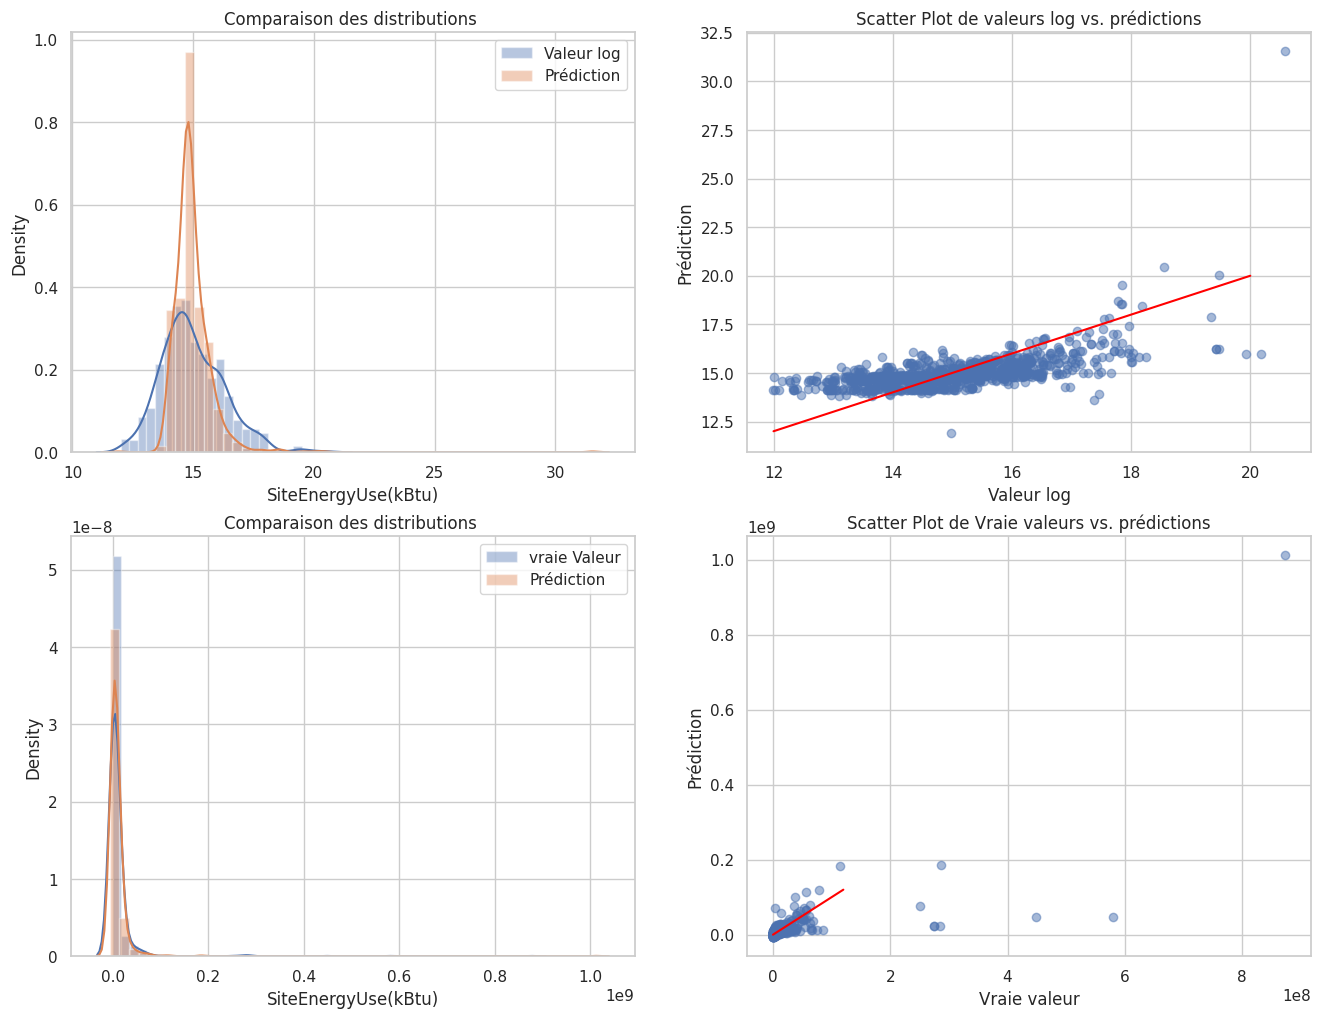

In [19]:
from sklearn.linear_model import LassoCV 
lr_Lasso_score = evaluate_model(data, 'SiteEnergyUse(kBtu)', LinearRegression(), LassoCV(alphas=(0.1, 1.0, 10.0)))


### Modèle : ElasticNetCV 

Données d'entraînement :  (3758, 12)
Données de test :  (940, 12)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,4,False
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle :  ElasticNetCV(alphas=(0.1, 1.0, 10.0))
Scores avec la cible transformée en log puis exp


,Training scores,Test scores log,Test scores
RMSE,0.911499,1.021302,6.964615e+11
MAE,0.706264,0.758891,2.272425e+10
R2,0.462407,0.380108,-2.606398e+08
Median Abs Err,0.589601,0.598296,1.457415e+06
Time,0.092855,0.002084,2.084494e-03


Scores avec cible non transformée


,Training scores,Test scores
R2,7.796346e-01,5.574261e-01
RMSE,1.167398e+07,2.869919e+07
Relative RMSE,1.102416e+00,3.284553e+00
MAE,4.898221e+06,6.699036e+06
Median Abs Err,2.524846e+06,2.484415e+06
Time,2.074192e-01,5.874634e-04


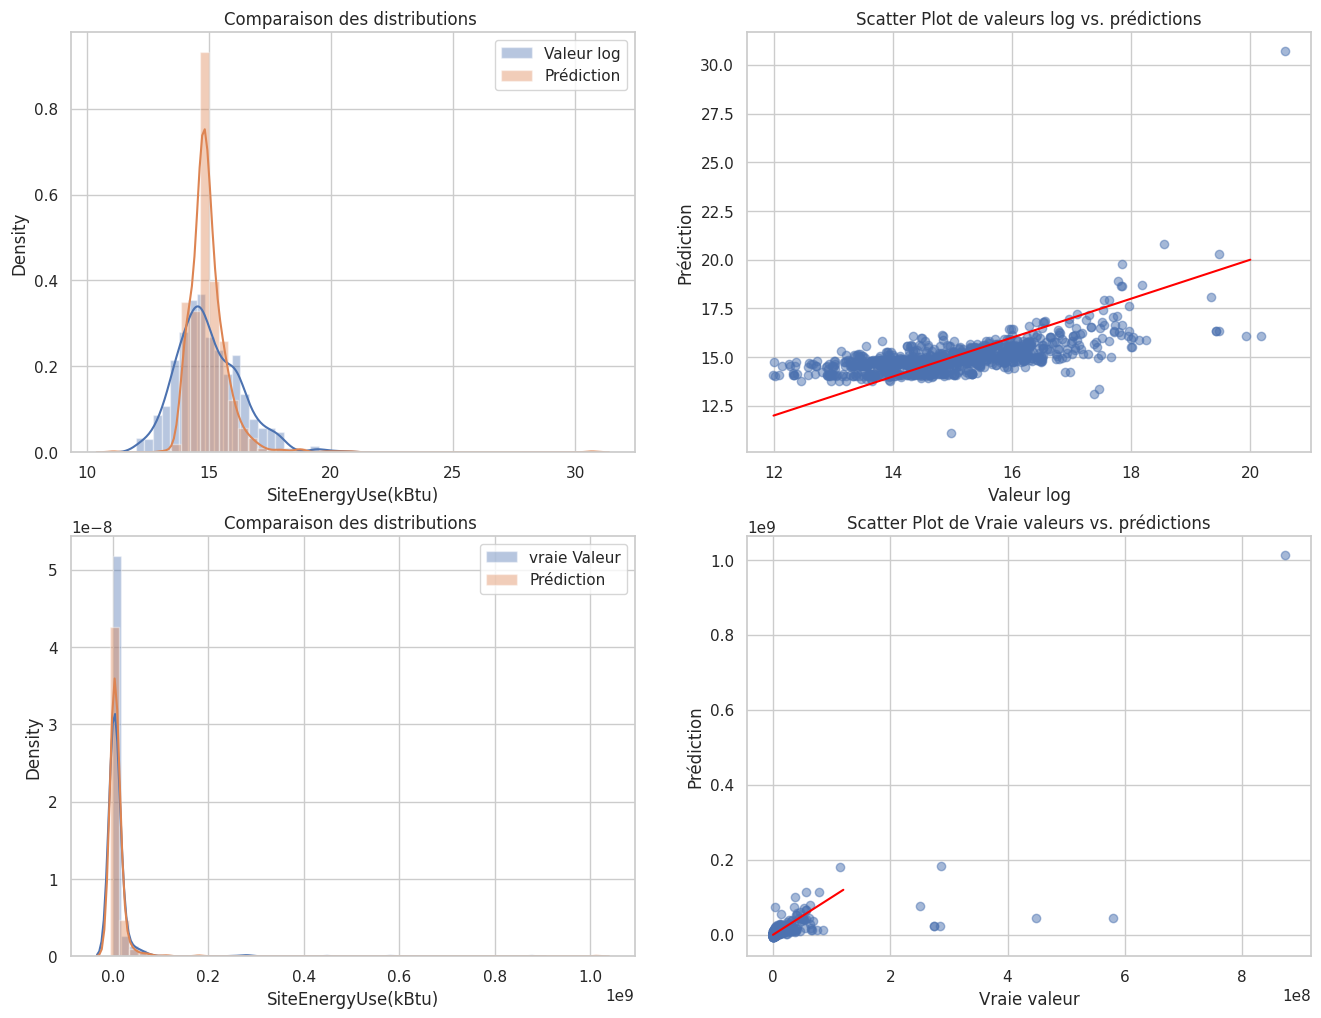

In [20]:
from sklearn.linear_model import ElasticNetCV 

lr_Elas_score = evaluate_model(data, 'SiteEnergyUse(kBtu)', LinearRegression(), ElasticNetCV(alphas=(0.1, 1.0, 10.0), l1_ratio=0.5))

- Nous constatons que les scores des modèles linéaires changent en fonction de la variable cible:
en effet, lorsqu'on utilise la variable cible sans transformation log, les scores sont meilleurs.
- Sans transformation de la variable cible, les modèles linéaires ont des scores similaires
.
Pour la suite, nous allons tester des modèles non linéaires pour prédire la variable cible en vraies grandeurs (sans transformation log)

## II - Modèles non linéaires :

Nous créons une nouvelle fonction preprocessing qui utilise le log de la variable cible pour l'encodage et la sélection de features et utilise les vraies valeurs dans le modèle

In [21]:
# fonction pretraitement

def preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model):
    # Séparation features et cible
    target = target
    X = data.drop([target], axis=1)
    y = data[target]

    # Transformation de la variable cible
    # y_log = y.apply(target_transformation)
    
    # Séparer les données en train et test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Séparation des variable numériques et catégorielles pour l'encodage
    train_categorical_features = X_train.select_dtypes(include='category')
    test_categorical_features = X_test.select_dtypes(include='category')
    
    train_numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
    test_numerical_features = X_test.select_dtypes(include=['int64', 'float64'])
    
    # Encodage des variables catégorielles
    train_categorical_features, test_categorical_features = encodage(train_categorical_features, test_categorical_features, y_train)
    
    # Fusion des variables catégorielles et numériques
    X_train = pd.merge(train_categorical_features, train_numerical_features, left_index=True, right_index=True)
    X_test = pd.merge(test_categorical_features, test_numerical_features,  left_index=True, right_index=True)

    # Sélection de features avec RFECV
    
    sv = RFECV(rfe_model, step=1, cv=5)
    sv.fit(X_train, y_train)
    selected_columns = [col for col, selected in zip(X_train.columns, sv.support_) if selected]
    X_train = X_train[selected_columns]
    X_test = sv.transform(X_test)
    
    # Accédez aux classements des fonctionnalités
    feature_ranking = sv.ranking_
    # Accédez aux fonctionnalités sélectionnées (True signifie sélectionné)
    selected_features = sv.support_
    
    feature_info = pd.DataFrame({
        'Feature': X.columns, 
        'Ranking': feature_ranking,
        'Selected': selected_features
    })
    print("Données d'entraînement : ", X_train.shape)
    print("Données de test : ", X_test.shape)
    print("Features Sélectionnées par la RFECV :")
    display(feature_info)

    # y_train = np.exp(y_train)
    # y_test = np.exp(y_test)
    return X_train, X_test, y_train, y_test

In [22]:
def graph_show(y_test,y_pred):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.distplot(y_test, ax = axes[0], label='vraie Valeur' )
    sns.distplot(y_pred, ax = axes[0], label='Prédiction')
    axes[0].set_title('Comparaison des distributions ')
    axes[0].legend()
    
    axes[1].scatter(y_test, y_pred, alpha=0.5)
    axes[1].plot([0, 1e8],[0, 1e8], color = 'red', linestyle = '-', linewidth = 1.5)
    axes[1].set_xlabel("Vraie valeur")
    axes[1].set_ylabel("Prédiction")
    axes[1].set_title("Scatter Plot de Vraie valeurs vs. prédictions")

    plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV
import shap

def evaluate_model_grid_CV_2(data, target, test_size, random_state, ref_model, prediction_model, param_grid):  
    warnings.filterwarnings("ignore")
    
    X_train, X_test, y_train, y_test = preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model)
    scaler = RobustScaler()
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)
    ])
    # Temps recherche hyperparapètres
    start_grid = time.time()
    # Recherche des meilleurs hyperparamètres en utilisant le pipeline
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error']
    grid_search = GridSearchCV(pipeline,
                               param_grid, 
                               cv=5, 
                               scoring=scoring,
                               refit="neg_mean_squared_error"
                              )

    grid_search.fit(X_train, y_train)
    end_grid = time.time()
    gridsearch_time = end_grid - start_grid

    cv_results = grid_search.cv_results_
    mean_mae = (-cv_results['mean_test_neg_mean_absolute_error']).mean()
    mean_rmse = np.sqrt((-cv_results['mean_test_neg_mean_squared_error']).mean())
    mean_relative_rmse = (mean_rmse/(y_train.max()-y_train.min()))*100
    mean_r2 = cv_results['mean_test_r2'].mean()
    mean_med_abs_err = -cv_results['mean_test_neg_median_absolute_error'].mean()

     #  les meilleurs hyperparamètres
    best_params = grid_search.best_params_
    
    
    # Le modèle avec les meilleurs hyperparamètres
    best_model = grid_search.best_estimator_
    
    # Prédictions avec le modèle optimisé
    # Temps de prédiction 
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    # Mesures des performances 
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)
    relative_rmse = (rmse/(y_test.max()-y_test.min()))*100

    print(f'Modèle : {prediction_model}')
    print(f'Meilleurs hyperparamètres: {best_params}')
    
    score_info = {"Gridsearch scores": [mean_r2, mean_rmse, mean_relative_rmse, mean_mae, mean_med_abs_err, gridsearch_time],
                  "Test scores": [r2, rmse, relative_rmse, mae, med_abs_err, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])

    display(df_score_info)
    
    graph_show(y_test,y_pred)

    
    return df_score_info, X_train, X_test, y_train, y_test


## II.1 - Modèle KernelRidge

- Pour visualiser l'impact des variable sur le modèle, nous utilisons la librairie Shap.
 - En raison de problème de mémoire, l'analyse sera resteinte sur 100 premières prédictions.

In [24]:
from sklearn.kernel_ridge import KernelRidge

Données d'entraînement :  (3758, 17)
Données de test :  (940, 17)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : KernelRidge()
Meilleurs hyperparamètres: {'model__alpha': 0.1, 'model__gamma': 0.01, 'model__kernel': 'polynomial'}


,Gridsearch scores,Test scores
R2,2.715440e-01,5.579175e-01
RMSE,1.973883e+07,2.868325e+07
Relative RMSE,1.864008e+00,3.282729e+00
MAE,5.690741e+06,8.440405e+06
Median Abs Err,1.866759e+06,2.654147e+06
Time,7.692399e+02,2.008691e-01


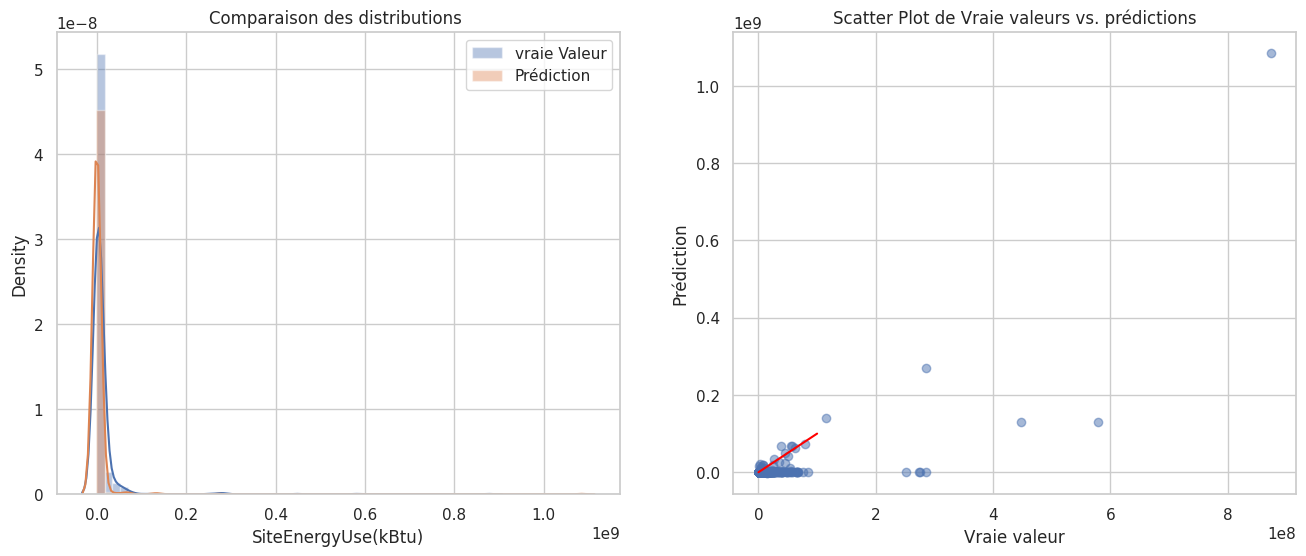

In [113]:
rfe_model = LinearRegression()
prediction_model = KernelRidge()
param_grid = {
    'model__alpha': [0.01, 0.1, 1.0],  # Différentes valeurs d'alpha à tester
    'model__kernel': ['laplacian', 'polynomial'],  # Différents types de noyaux à tester
    'model__gamma': [0.001, 0.01, 0.1, 1.0]  # Hyperparamètre spécifique au noyau 
}
test_size = 0.2
random_state = 12
lr_kern_score, X_train_2, X_test_2, y_train_2, y_test_2 = evaluate_model_grid_CV_2(data,
                                                                                   'SiteEnergyUse(kBtu)',
                                                                                   test_size,
                                                                                   random_state,
                                                                                   rfe_model, 
                                                                                   prediction_model, 
                                                                                   param_grid)

In [29]:
KernelRdg = list([5.579175e-01, 2.868325e+07, 3.282729e+00, 8.440405e+06, 2.654147e+06, 2.008691e-01, 7.692399e+02])
KernelRdg                 

[0.5579175, 28683250.0, 3.282729, 8440405.0, 2654147.0, 0.2008691, 769.2399]

- Nous avons utilisé la régression linéaire pour la sélection de variable. La RFE a retenu toutes les variables.
- Avec le modèle KernelRidge(alpha=0.1, gamma=0.01, kernel='polynomial') , nous avons obtenu un meilleur score de détermination (r2_score=0.55) cependant le score test de la validation croisée est plus bas.

## II.2 - Modèle SVR (Support Vector Regression)

Données d'entraînement :  (3758, 7)
Données de test :  (940, 7)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,6,False
1,PrimaryPropertyType,9,False
2,LargestPropertyUseType,8,False
3,Neighborhood,11,False
4,CouncilDistrictCode,10,False
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : SVR()
Meilleurs hyperparamètres: {'model__C': 1, 'model__epsilon': 0.5, 'model__gamma': 'auto', 'model__kernel': 'poly'}


,Gridsearch scores,Test scores
R2,-6.947202e-02,3.946634e-01
RMSE,2.573553e+07,3.356412e+07
Relative RMSE,2.430298e+00,3.841332e+00
MAE,6.624837e+06,7.720956e+06
Median Abs Err,1.737510e+06,1.575856e+06
Time,1.361913e+02,7.916880e-02


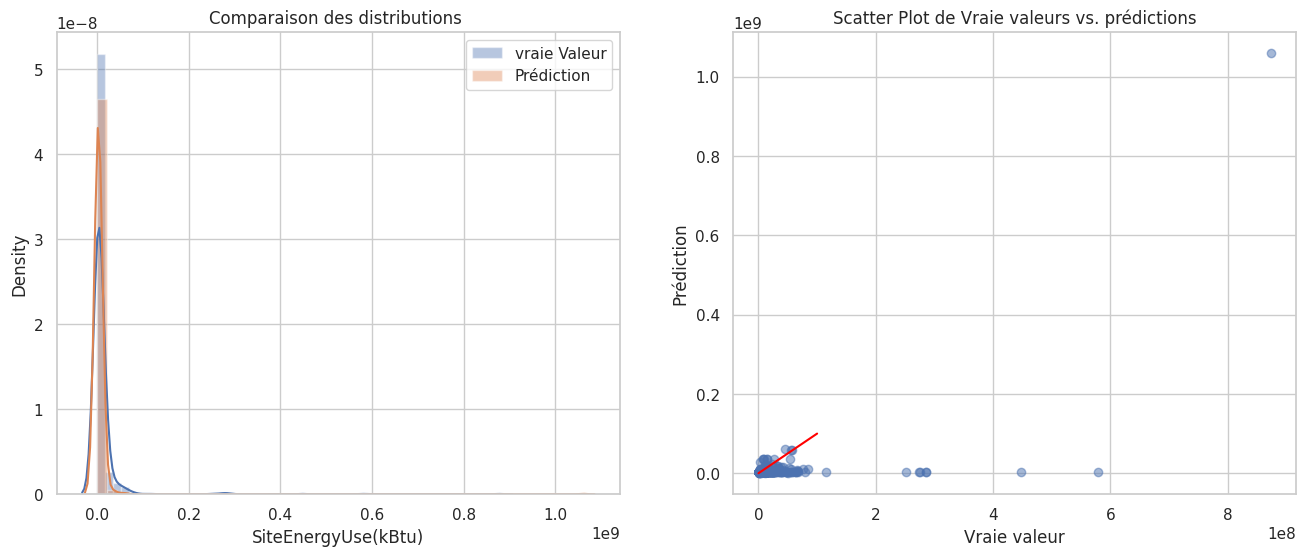

In [115]:
from sklearn.svm import SVR

rfe_model = RidgeCV(alphas=(0.1, 1.0, 10.0))
prediction_model = SVR()
param_grid = {
    'model__kernel': ['poly', 'rbf'], # Différents types de noyaux à tester
    'model__gamma': ['scale', 'auto'],
    'model__C': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.5]
}
test_size = 0.2
random_state = 12
rdg_SVR_score, X_train_3, X_test_3, y_train_3, y_test_3 = evaluate_model_grid_CV_2(data, 
                                                                                 'SiteEnergyUse(kBtu)', 
                                                                                 test_size,
                                                                                 random_state,
                                                                                 rfe_model, 
                                                                                 prediction_model, 
                                                                                 param_grid)

In [28]:
SVR = list([3.946634e-01, 3.356412e+07, 3.841332e+00, 7.720956e+06, 1.575856e+06, 7.916880e-02, 1.361913e+02])
SVR

[0.3946634, 33564120.0, 3.841332, 7720956.0, 1575856.0, 0.0791688, 136.1913]

- Ici, nous avons utilisé la régression Ridge pour la sélection des features, la RFE a retenu 7 variables parmi les 17 présentes.
- Le modèle SVR est moins perfomant que KernelRidge et les modèles linéaires. Le r2_score de la validation croisée est négatif.

- Les modèles non linéaires sont plus gourmands en temps, pour la recherche des meilleurs hyperparamètres, nous allons utiliser la RandomizedSearchCV à la place de GridSearchCV.


#### Fonction avec Random Search CV :

In [25]:
from sklearn.model_selection import RandomizedSearchCV

def evaluate_model_random_CV_2(data, target, test_size, random_state, rfe_model, prediction_model, param_grid):
    warnings.filterwarnings("ignore")
    X_train, X_test, y_train, y_test = preprocessing_without_ln_2(data, target, test_size, random_state, rfe_model)
    scaler = RobustScaler()
    # Le pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', prediction_model)
    ])
    
    # Temps recherche hyperparapètres
    start_grid = time.time()
    # Recherche des meilleurs hyperparamètres en utilisant le pipeline
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_median_absolute_error']
    grid_search = RandomizedSearchCV(pipeline,
                                     param_grid, 
                                     cv=5,
                                     n_iter=15,
                                     scoring=scoring,
                                     refit="neg_mean_squared_error"
                                    )
 
    grid_search.fit(X_train, y_train)
    end_grid = time.time()
    gridsearch_time = end_grid - start_grid

    cv_results = grid_search.cv_results_
    train_mae = (-cv_results['mean_test_neg_mean_absolute_error']).mean()
    train_rmse = np.sqrt((-cv_results['mean_test_neg_mean_squared_error']).mean())
    train_relative_rmse = (train_rmse/(y_train.max()-y_train.min()))*100
    train_r2 = cv_results['mean_test_r2'].mean()
    train_med_abs_err = -cv_results['mean_test_neg_median_absolute_error'].mean()

    # Obtenez les meilleurs hyperparamètres
    best_params = grid_search.best_params_
    
    # Entraînez le modèle avec les meilleurs hyperparamètres
    best_model = grid_search.best_estimator_


    # train_rmse = math.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
    # train_mae = mean_absolute_error(y_train, best_model.predict(X_train))
    # train_r2 = r2_score(y_train, best_model.predict(X_train))
    # train_med_abs_err = median_absolute_error(y_train, best_model.predict(X_train))
    # train_relative_rmse = (train_rmse/(y_train.max()-y_train.min()))*100
    
    # Prédictions avec le modèle optimisé
    # Temps de prédiction
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    # Mesures des performances - cible
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_err = median_absolute_error(y_test, y_pred)
    relative_rmse = (rmse/(y_test.max()-y_test.min()))*100

    print(f'Modèle : {prediction_model}')
    print(f'Meilleurs hyperparamètres: {best_params}')
    

    score_info = {"Training scores" : [train_r2, train_rmse, train_relative_rmse, train_mae, train_med_abs_err, gridsearch_time],
                  "Test scores": [r2, rmse, relative_rmse, mae, med_abs_err, prediction_time]
                 }
    df_score_info = pd.DataFrame(score_info,
                          index = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Time'])
    display(df_score_info)
    graph_show(y_test,y_pred)
    
    return df_score_info, X_train, X_test, y_train, y_test

 - Le temps d'entrainement plus court avec RandomizedSearchCV
 - Nous avons utiliser, pour ce test, la régression linéaire pour la selection de features, les résultats sont meilleurs que ceux obtenu avec la méthode Ridge. Les scores sont néamoins inférieurs à ceux obtenus par le modèle KernelRidge.

Passons aux modèles ensemblistes


## III - Modèles ensemblistes :

### III. 1 - Random Forrest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor


Données d'entraînement :  (3758, 17)
Données de test :  (940, 17)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : RandomForestRegressor()
Meilleurs hyperparamètres: {'model__n_estimators': 500, 'model__max_depth': 100}


,Training scores,Test scores
R2,7.733958e-01,6.127022e-01
RMSE,1.634138e+07,2.684722e+07
Relative RMSE,1.543174e+00,3.072599e+00
MAE,2.226892e+06,3.524431e+06
Median Abs Err,6.075692e+05,5.249475e+05
Time,1.495133e+03,2.979560e-01


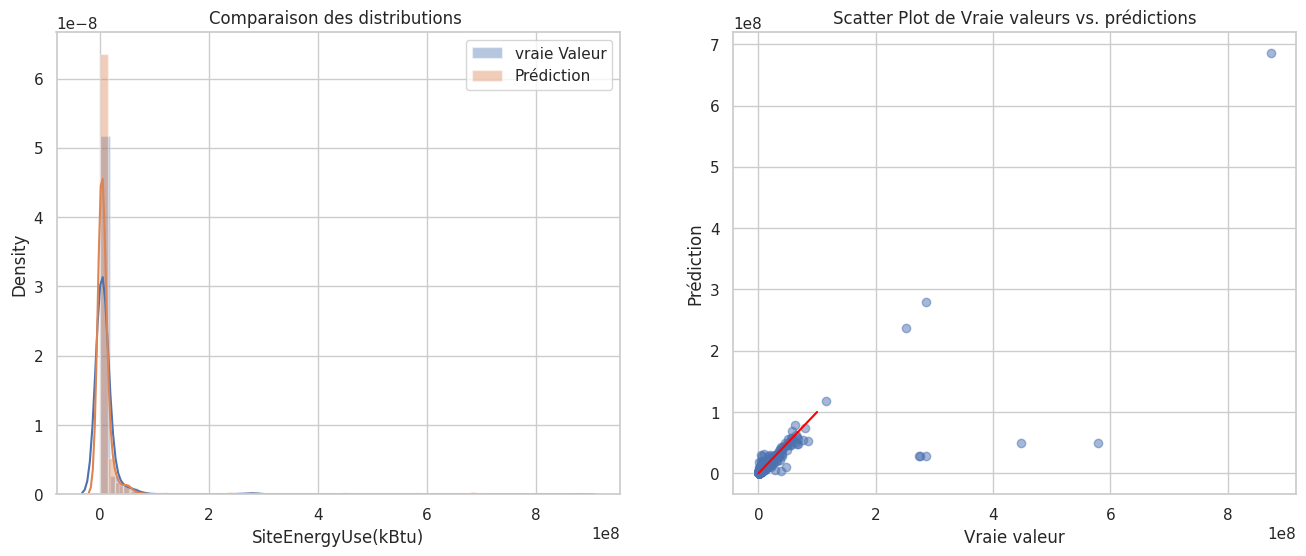

In [39]:
rfe_model = LinearRegression()
prediction_model = RandomForestRegressor()
param_grid = {'model__max_depth': [10, 20, 50, 70, 90, 100, None],
              'model__n_estimators': [100, 500, 1000]
             }
test_size = 0.2
random_state = 12
lr_RFR_score_2, X_train_71, X_test_71, y_train_71, y_test_71 = evaluate_model_random_CV_2(data, 
                                                                                      'SiteEnergyUse(kBtu)',
                                                                                        test_size,
                                                                                        random_state,
                                                                                        rfe_model, 
                                                                                        prediction_model, 
                                                                                        param_grid)

In [30]:
RFR = list([6.127022e-01, 2.684722e+07, 3.072599e+00, 3.524431e+06, 5.249475e+05, 2.979560e-01, 1.495133e+03])
RFR

[0.6127022, 26847220.0, 3.072599, 3524431.0, 524947.5, 0.297956, 1495.133]

 - Nous avons utliser le modèle régression linéaire pour la selection des features, la RFE a retenu 13 variables parmi les 17 présentes.
 - Le modèle RandomForest a un meilleur score de détermination (r2_score = 0.61) et un meilleur r2_score sur les données de validation.
 - Un RMSE relatif plus bas comparé aux modèles linéaires et non linéaires.

Visualisons les variables qui présentent un impact sur le modèle :

In [65]:
model_7 = RandomForestRegressor(n_estimators=100, max_depth=100) 

model_7.fit(X_train_7, y_train_7)

# Créer un objet explainer SHAP
explainer_7 = shap.Explainer(model_7.predict, X_train_7, feature_names=X_train_7.columns)

# Obtenir des explications SHAP pour les 100 premières prédictions
shap_values_7 = explainer_7(X_test_7[0:940])

PermutationExplainer explainer: 941it [08:23,  1.83it/s]                        


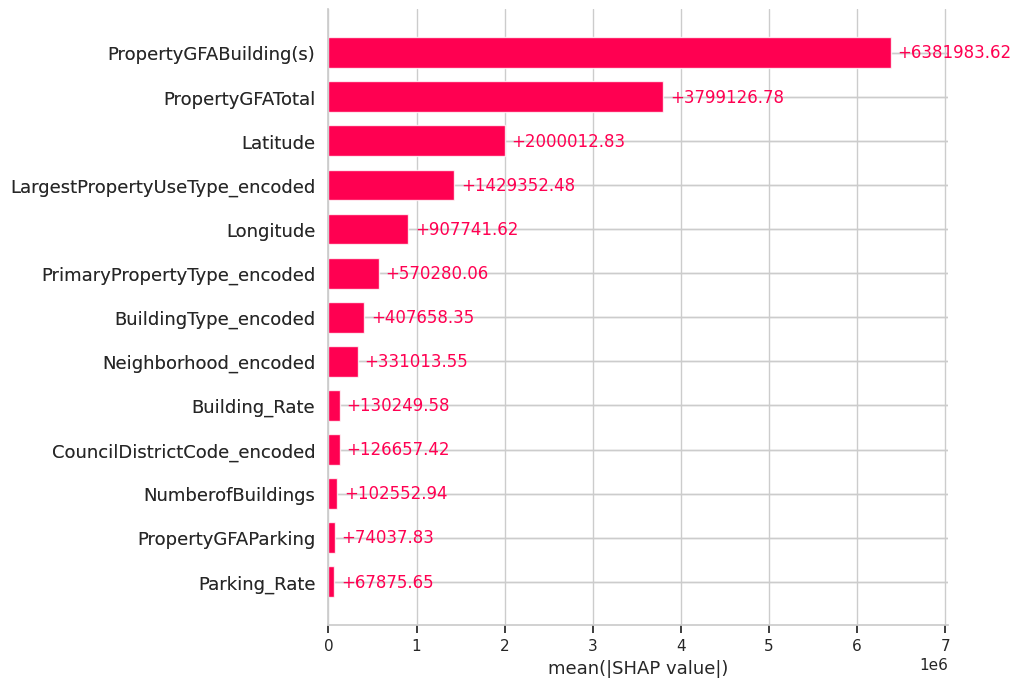

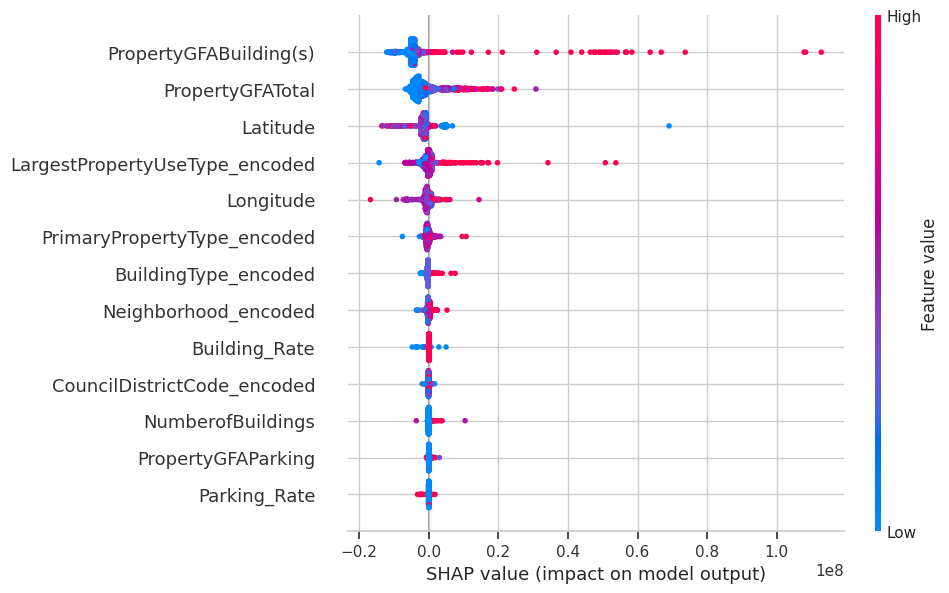

In [66]:
shap.plots.bar(shap_values_7, max_display=13)
shap.plots.beeswarm(shap_values_7, max_display=13)

##### Interprétation :
 - La variable PropertyGFATotal semble avoir un plus grand impact sur les prédiction avec le modèle RandomForest
 - Nous constatons que la Longitude a un plus grand impact que la Latitude, ce qui peut être explique par la frome de la ville de Seattle dont la longueur est plus importante que la largeur.

### 2. Modèle XGBoost

In [32]:
from xgboost import XGBRegressor

Données d'entraînement :  (3758, 17)
Données de test :  (940, 17)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,1,True
1,PrimaryPropertyType,1,True
2,LargestPropertyUseType,1,True
3,Neighborhood,1,True
4,CouncilDistrictCode,1,True
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Meilleurs hyperparamètres: {'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.2}


,Training scores,Test scores
R2,7.381198e-01,6.335910e-01
RMSE,1.717256e+07,2.611318e+07
Relative RMSE,1.621666e+00,2.988591e+00
MAE,3.053462e+06,4.219940e+06
Median Abs Err,1.386075e+06,1.174892e+06
Time,1.124031e+01,1.891136e-03


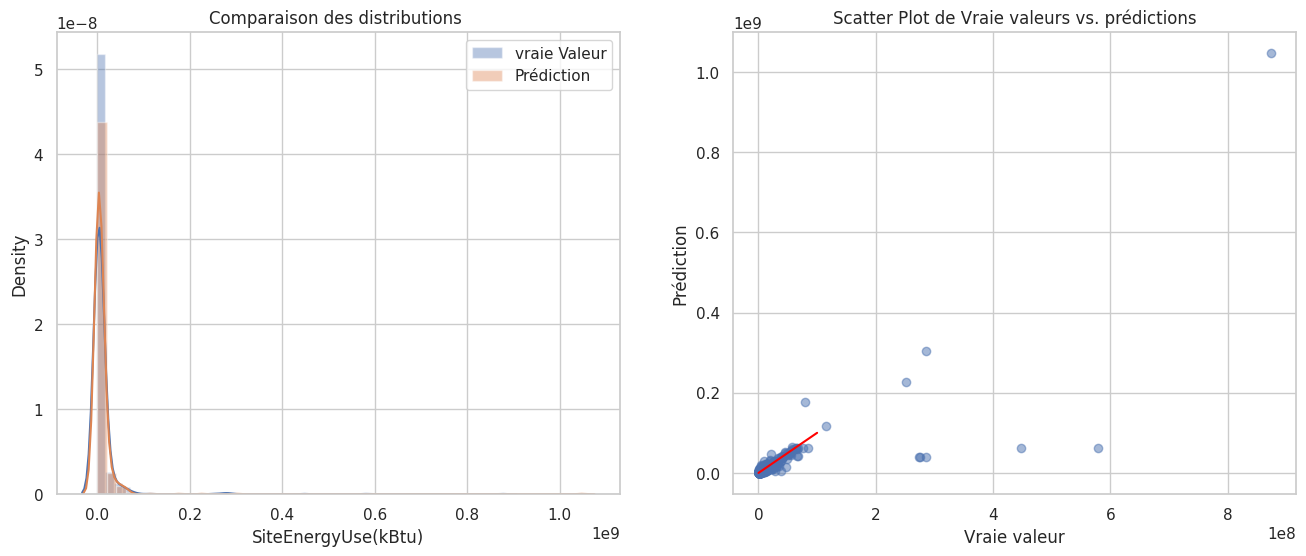

In [52]:
rfe_model = LinearRegression()
prediction_model = XGBRegressor()
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5]
}
test_size = 0.2
random_state = 12
lr_xgb_score, X_train_9, X_test_9, y_train_9, y_test_9 = evaluate_model_random_CV_2(data,
                                                                                  'SiteEnergyUse(kBtu)',
                                                                                    test_size,
                                                                                    random_state,
                                                                                    rfe_model,
                                                                                    prediction_model, 
                                                                                    param_grid)

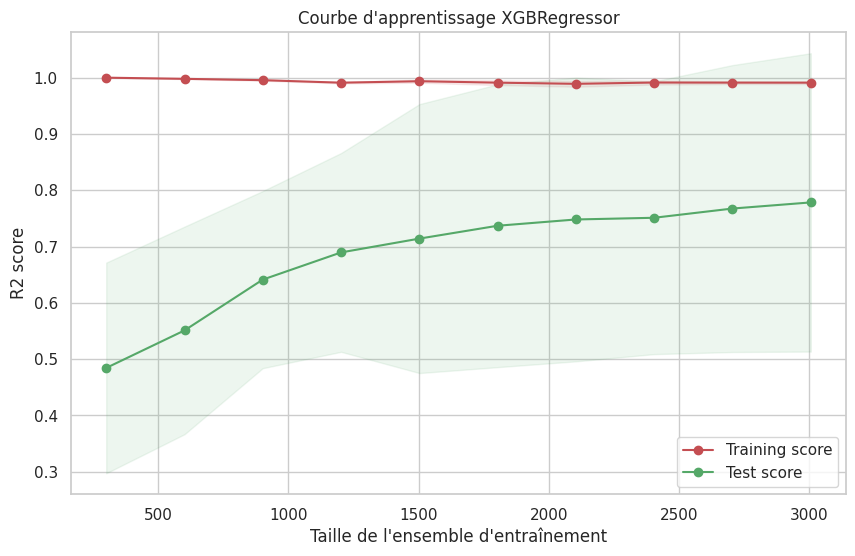

In [68]:
from sklearn.model_selection import learning_curve
model_xgb = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.2)

train_sizes, train_scores, test_scores = learning_curve(model_xgb,
                                                        X_train_9,
                                                        y_train_9,
                                                        cv=5,
                                                        scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Courbe d'apprentissage XGBRegressor")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("R2 score")
plt.grid(True)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score ")

plt.legend(loc="lower right")
plt.show()

Données d'entraînement :  (3758, 13)
Données de test :  (940, 13)
Features Sélectionnées par la RFECV :


,Feature,Ranking,Selected
0,BuildingType,2,False
1,PrimaryPropertyType,3,False
2,LargestPropertyUseType,1,True
3,Neighborhood,4,False
4,CouncilDistrictCode,5,False
5,BuildingAge,1,True
6,Latitude,1,True
7,Longitude,1,True
8,NumberofBuildings,1,True
9,NumberofFloors,1,True


Modèle : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Meilleurs hyperparamètres: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 300}


,Gridsearch scores,Test scores
R2,8.365303e-01,8.866144e-01
RMSE,1.218480e+07,4.002454e+06
Relative RMSE,1.150654e+00,2.727716e+00
MAE,3.514826e+06,1.476902e+06
Median Abs Err,1.666925e+06,6.522830e+05
Time,1.979433e+01,2.299213e-02


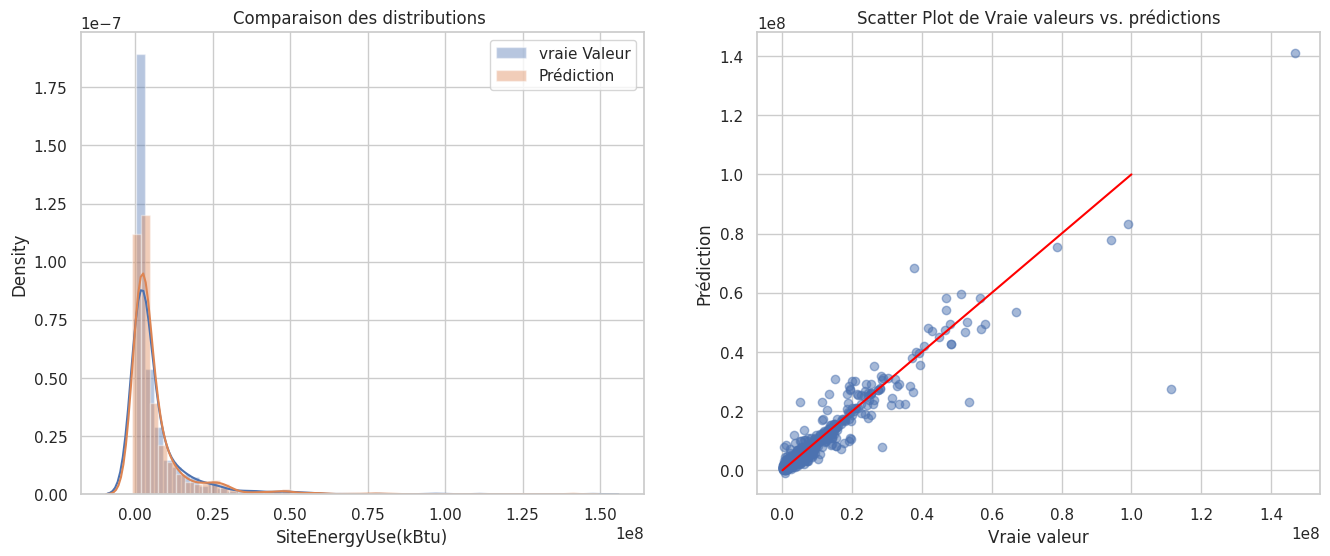

In [33]:
rfe_model = LinearRegression()
prediction_model = XGBRegressor()
param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5]
}
test_size = 0.2
random_state = 10
lr_xgb_score_2, X_train_91, X_test_91, y_train_91, y_test_91 = evaluate_model_grid_CV_2(data,
                                                                                  'SiteEnergyUse(kBtu)',
                                                                                    test_size,
                                                                                    random_state,
                                                                                    rfe_model,
                                                                                    prediction_model, 
                                                                                    param_grid)

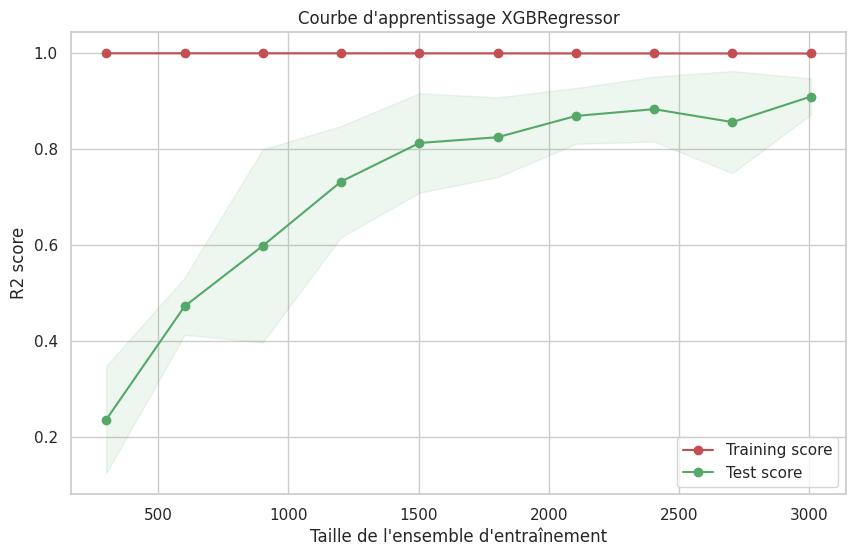

In [65]:
from sklearn.model_selection import learning_curve
model_xgb = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.2)

train_sizes, train_scores, test_scores = learning_curve(model_xgb,
                                                        X_train_91,
                                                        y_train_91,
                                                        cv=5,
                                                        scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Courbe d'apprentissage XGBRegressor")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("R2 score")
plt.grid(True)


plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score ")

plt.legend(loc="lower right")
plt.show()

 - Le modèle XGBoost a de meilleurs performances et un temps plus court que le modèle RandomForest.
   
Passons aux features importances:

In [69]:
import shap
model_9 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.2)

model_9.fit(X_train_91, y_train_91)

# Créer un objet explainer SHAP
explainer_9 = shap.Explainer(model_9.predict, X_train_91, feature_names=X_train_91.columns)

# Obtenir des explications SHAP 
shap_values_9 = explainer_9(X_test_91[0:940])

PermutationExplainer explainer: 941it [02:01,  7.66it/s]                        


In [70]:
shap.initjs()

#### Feature importance :

##### Analyse globale des features :

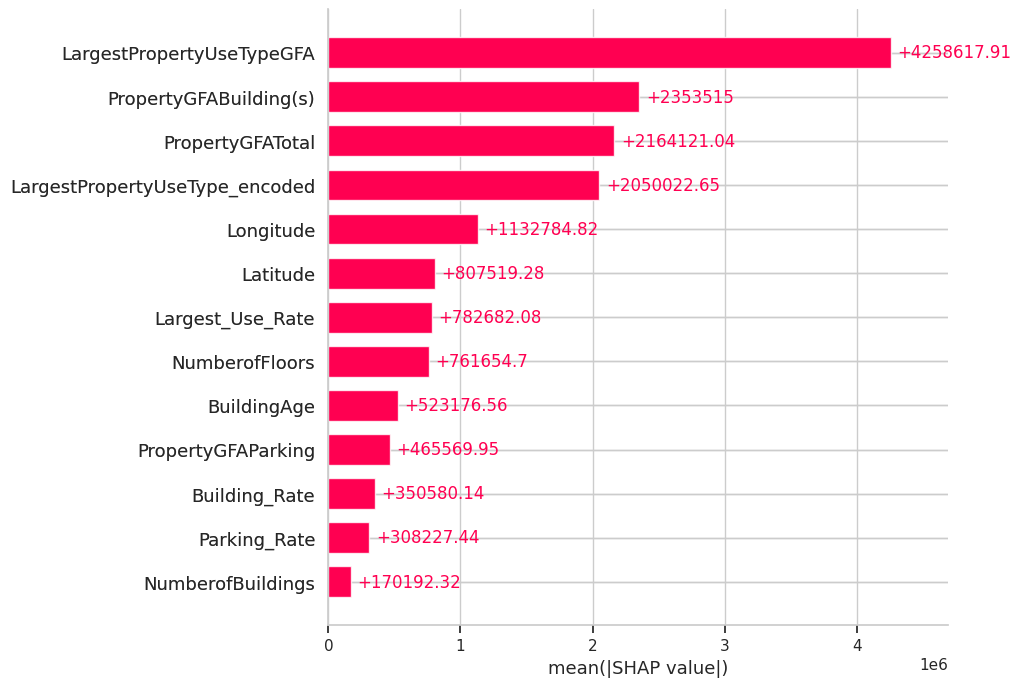

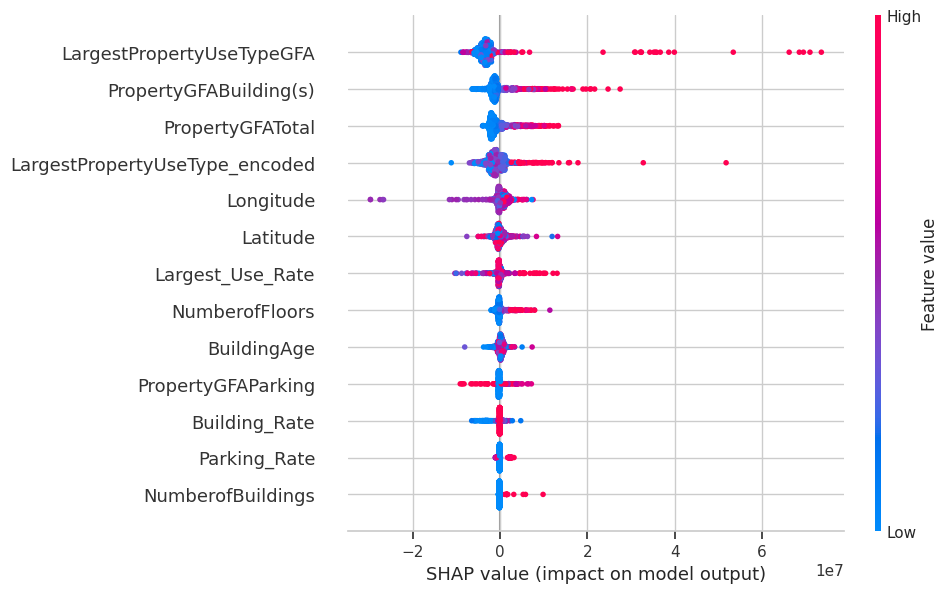

In [71]:
shap.plots.bar(shap_values_9, max_display=14)
shap.plots.beeswarm(shap_values_9, max_display=14)

##### Interprétation :
 - La variable LargestPropertyUseTypeGFA semble avoir le plus grand impact sur le modèle XGboost.
 - Comme avec le modèle RandomForest, l'impact de la longitude est plus important que la latitude.


#### Analyse locale :

- Pour visualiser l'impact de la feature PropertyGFABuilding(s) sur une prédiction, nous allons comparer deux prédictions pour lesquelles cette variable est descriminante.
- 1er cas : PropertyGFABuilding(s)=36 000 (pieds carrés)
- 2eme cas : PropertyGFABuilding(s)= (pieds carrés)

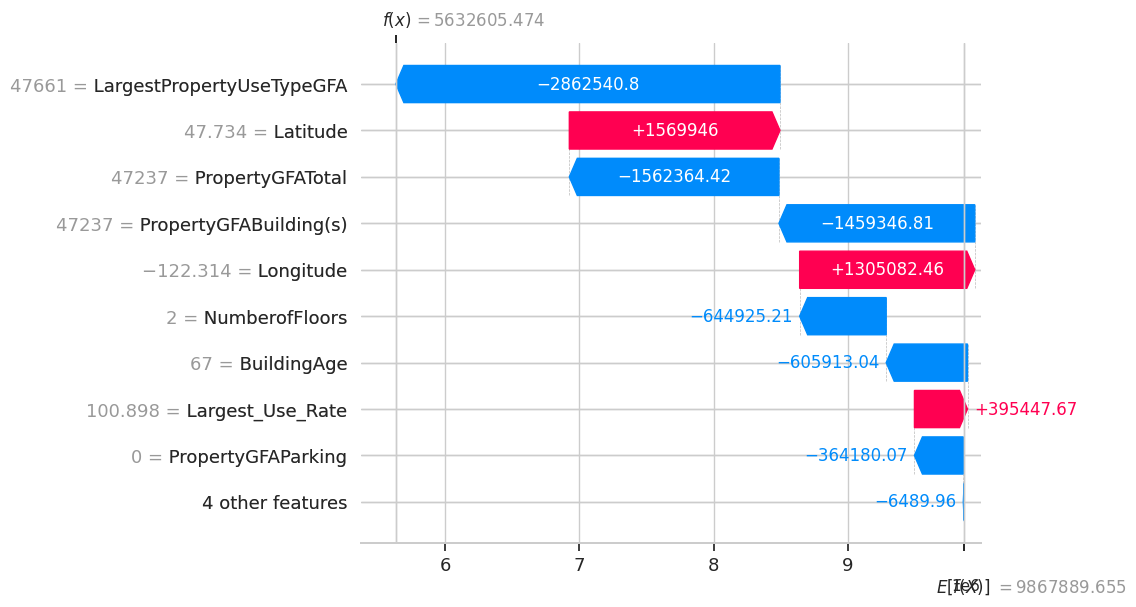

In [101]:
shap.plots.waterfall(shap_values_9[20])
shap.plots.force(shap_values_9[20])

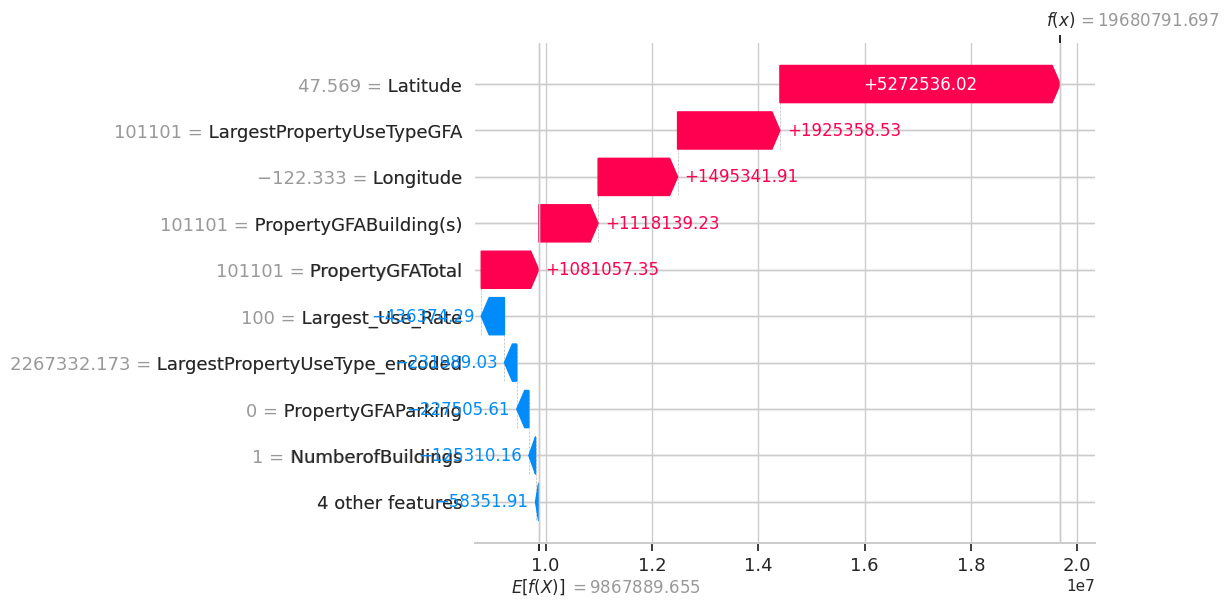

In [99]:
shap.plots.waterfall(shap_values_9[0])
shap.plots.force(shap_values_9[0])

Nous comparons ici deux prédictions pour lesquelles la feature PropertyGFABuilding(s) est descriminate, une grande et une petite valeur:

Nous constatons que dans le premeirs cas, la variable a une contribution positive (+13 111 151). Dans le 2ème cas, la contribution est néagtive (-3 897 597).

In [26]:
lr = list(lr_score['Test scores'])
lr.append(lr_score.loc['Time'][0])
lr

[0.5611853208001357,
 28577045.17871367,
 3.2705739167851315,
 6733882.951877897,
 2554920.9305904363,
 0.0030815601348876953,
 0.025600433349609375]

In [ ]:
rdg_SVR = 

## IV- Comparaison des modèles :

In [34]:
# On regroupe les scores obtenus sur les données de test
lr = list(lr_score['Test scores'])
lr.append(lr_score.loc['Time'][0])

ridge = list(lr_Ridge_score['Test scores'])
ridge.append(lr_Ridge_score.loc['Time'][0])

lasso = list(lr_Lasso_score['Test scores'])
lasso.append(lr_Lasso_score.loc['Time'][0])

ElasNet = list(lr_Elas_score['Test scores'])
ElasNet.append(lr_Elas_score.loc['Time'][0])

kernelRdg = list(lr_kern_score['Test scores'])
kernelRdg.append(lr_kern_score.loc['Time'][0])

SVR = list(lr_SVR_score['Test scores'])
SVR.append(lr_SVR_score.loc['Time'][0])

RFR = list(lr_RFR_score['Test scores'])
RFR.append(lr_RFR_score.loc['Time'][0])

Xgb = list(lr_xgb_score_2['Test scores'])
Xgb.append(lr_xgb_score_2.loc['Time'][0])

In [36]:
metriques = ['R2', 'RMSE', 'Relative RMSE', 'MAE', 'Median Abs Err', 'Prediction time', 'Training time']

df = {
    'lr': lr,
    'Ridge': ridge,
    'Lasso': lasso,
    'ElastNet': ElasNet,
    'KernelRdg': KernelRdg,
    'SVR': SVR,
    'RFR': RFR,
    'XGBoost': Xgb
}

# Créez un DataFrame à partir du dictionnaire
df_score = pd.DataFrame(df, index=metriques)
df_score

,lr,Ridge,Lasso,ElastNet,KernelRdg,SVR,RFR,XGBoost
R2,5.611853e-01,5.607660e-01,5.611323e-01,5.574261e-01,5.579175e-01,3.946634e-01,6.127022e-01,8.866144e-01
RMSE,2.857705e+07,2.859070e+07,2.857877e+07,2.869919e+07,2.868325e+07,3.356412e+07,2.684722e+07,4.002454e+06
Relative RMSE,3.270574e+00,3.272136e+00,3.270772e+00,3.284553e+00,3.282729e+00,3.841332e+00,3.072599e+00,2.727716e+00
MAE,6.733883e+06,6.726776e+06,6.729439e+06,6.699036e+06,8.440405e+06,7.720956e+06,3.524431e+06,1.476902e+06
Median Abs Err,2.554921e+06,2.538244e+06,2.546104e+06,2.484415e+06,2.654147e+06,1.575856e+06,5.249475e+05,6.522830e+05
Prediction time,3.081560e-03,1.486063e-03,2.682447e-03,5.874634e-04,2.008691e-01,7.916880e-02,2.979560e-01,2.299213e-02
Training time,2.560043e-02,8.587265e-02,8.605146e-02,2.074192e-01,7.692399e+02,1.361913e+02,1.495133e+03,1.979433e+01


In [37]:
df_score.to_csv('df_score.csv')

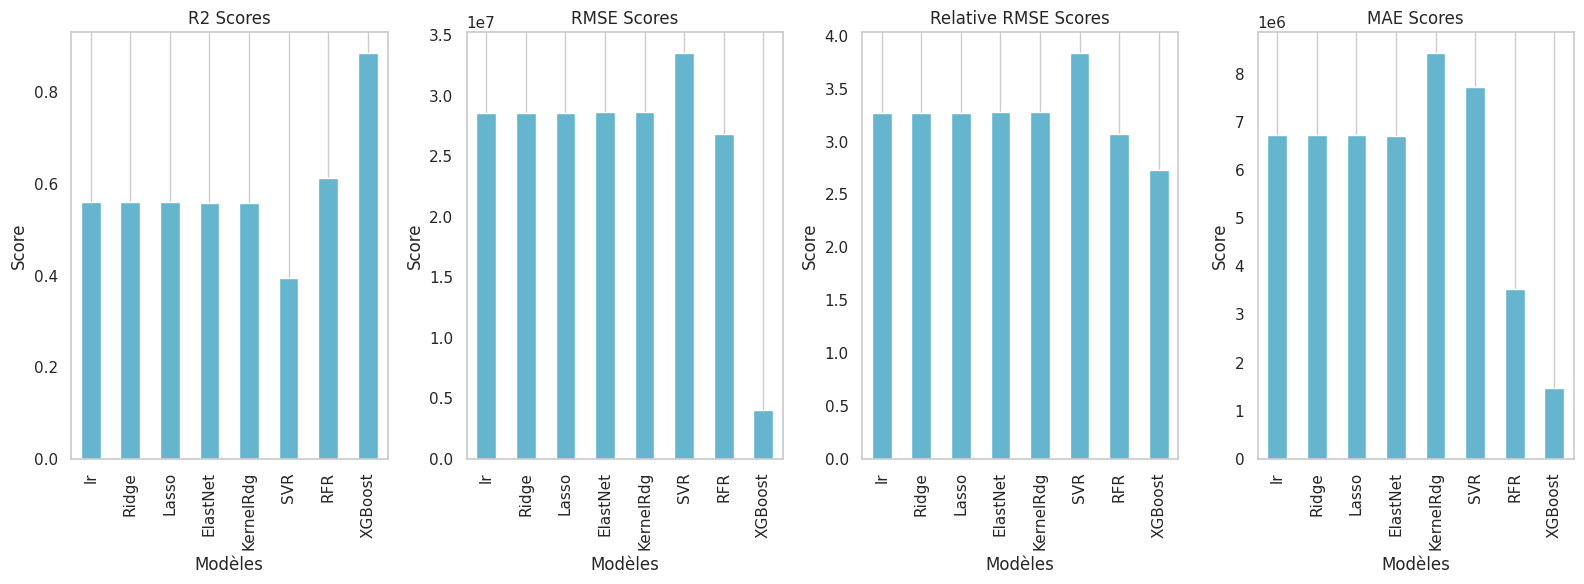

In [38]:
# Transposer le DataFrame pour avoir les modèles en colonnes et les métriques en index
df_score_transposed = df_score.T

# Sélectionnez les métriques que vous souhaitez afficher
metrics_to_plot = ['R2', 'RMSE', 'Relative RMSE', 'MAE']

# Créez un subplot avec autant de sous-graphiques que de métriques à afficher
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(16, 6))

# Parcourez les métriques et tracez les barres pour chaque métrique
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    df_score_transposed[metric].plot(kind='bar', ax=ax, color='c')
    ax.set_title(f'{metric} Scores')
    ax.set_xlabel('Modèles')
    ax.set_ylabel('Score')
    ax.grid(axis='y')

# Ajustez la disposition des sous-graphiques
plt.tight_layout()

# Affichez le graphique
plt.show()


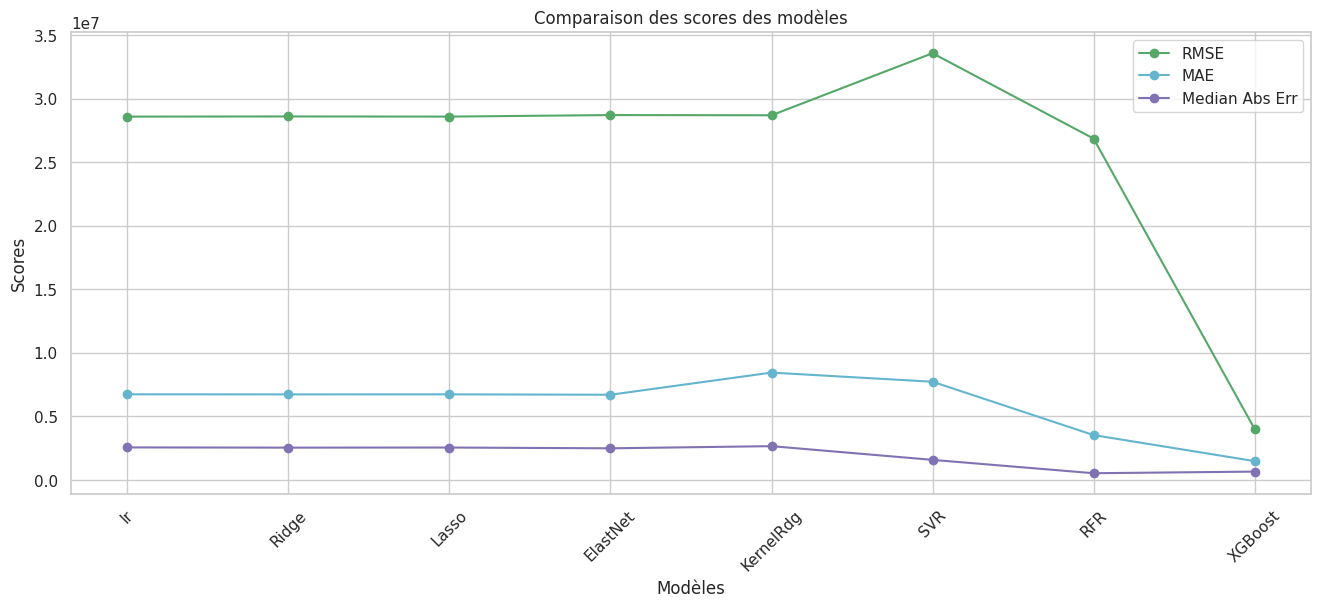

In [39]:
colors = ['g', 'c', 'm']
metrics_to_plot = ['RMSE', 'MAE', 'Median Abs Err']
# Tracé des scores
plt.figure(figsize=(16, 6))  
for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score.columns, df_score.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

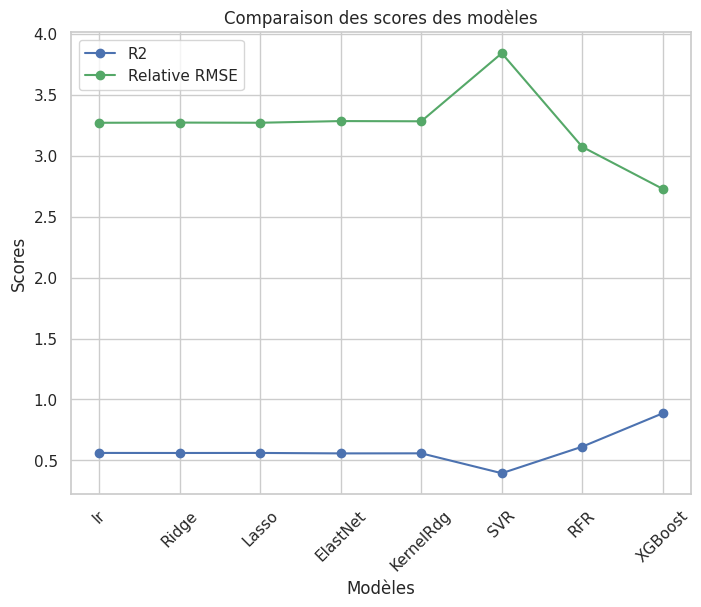

In [40]:
colors = ['b', 'g']
metrics_to_plot = ['R2', 'Relative RMSE']
# Tracé des scores
plt.figure(figsize=(8, 6)) 

for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score.columns, df_score.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

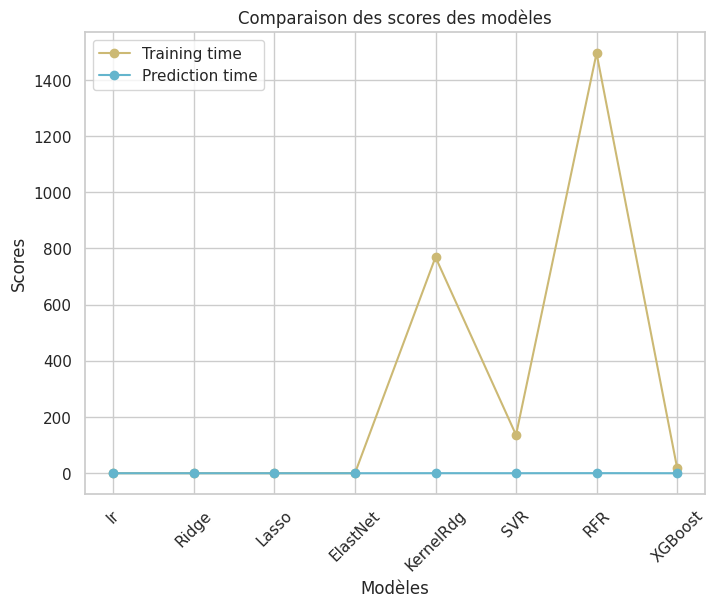

In [41]:
colors = ['y', 'c']
metrics_to_plot = ['Training time', 'Prediction time']
# Tracé des scores
plt.figure(figsize=(8, 6)) 

for score, color in zip(metrics_to_plot, colors):
    plt.plot(df_score.columns, df_score.loc[score], label=score, marker='o', color=color)

plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.title('Comparaison des scores des modèles')
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

Pour la prédiction de la consommation totale d'énergie, nous avons retenu le modèle XGBoost(n_estimators=300, max_depth=5, learning_rate=0.1), ayant les meilleurs scores et un temps de prédiction plus court que le modèle RandomForest.



## V- Modèle final :

In [103]:
print("Modèle final : XGBRegressor")
print("Meilleurs paramètres : n_estimators=300, max_depth=5, learning_rate=0.2")
lr_xgb_score_2

Modèle final : XGBRegressor
Meilleurs paramètres : n_estimators=300, max_depth=5, learning_rate=0.2


,Gridsearch scores,Test scores
R2,8.365303e-01,8.866144e-01
RMSE,1.218480e+07,4.002454e+06
Relative RMSE,1.150654e+00,2.727716e+00
MAE,3.514826e+06,1.476902e+06
Median Abs Err,1.666925e+06,6.522830e+05
Time,4.875211e+01,3.101587e-03
